In [ ]:
# Install required libraries
!pip install pandas pillow pyyaml

In [ ]:
# Download the GTSRB dataset
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip GTSRB_Final_Training_Images.zip -d GTSRB

Streaming output truncated to the last 5000 lines.
  inflating: GTSRB/GTSRB/Final_Training/Images/00035/00000_00019.ppm  
  inflating: GTSRB/GTSRB/Final_Training/Images/00035/00000_00020.ppm  
  inflating: GTSRB/GTSRB/Final_Training/Images/00035/00000_00021.ppm  
  inflating: GTSRB/GTSRB/Final_Training/Images/00035/00000_00022.ppm  
  inflating: GTSRB/GTSRB/Final_Training/Images/00035/00000_00023.ppm  
  inflating: GTSRB/GTSRB/Final_Training/Images/00035/00000_00024.ppm  
  inflating: GTSRB/GTSRB/Final_Training/Images/00035/00000_00025.ppm  
  inflating: GTSRB/GTSRB/Final_Training/Images/00035/00000_00026.ppm  
  inflating: GTSRB/GTSRB/Final_Training/Images/00035/00000_00027.ppm  
  inflating: GTSRB/GTSRB/Final_Training/Images/00035/00000_00028.ppm  
  inflating: GTSRB/GTSRB/Final_Training/Images/00035/00000_00029.ppm  
  inflating: GTSRB/GTSRB/Final_Training/Images/00035/00001_00000.ppm  
  inflating: GTSRB/GTSRB/Final_Training/Images/00035/00001_00001.ppm  
  inflating: GTSRB/GTSRB/F

In [ ]:
# Import libraries
import os
import pandas as pd
from PIL import Image
import yaml

In [ ]:
# Set up directories
root_dir = 'GTSRB/GTSRB/Final_Training/Images'
output_dir = 'GTSRB_YOLO'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, 'images', 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'images', 'val'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'labels', 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'labels', 'val'), exist_ok=True)

In [ ]:
# Get list of class folders (00000 to 00042)
class_folders = [f for f in os.listdir(root_dir) if f.isdigit()]
class_folders.sort()

In [ ]:
# Process each class folder
for class_folder in class_folders:
    class_id = int(class_folder)
    csv_file = os.path.join(root_dir, class_folder, f'GT-{class_folder}.csv')
    df = pd.read_csv(csv_file, sep=';')

    # Shuffle and split into train (80%) and val (20%)
    df = df.sample(frac=1).reset_index(drop=True)
    num_train = int(len(df) * 0.8)
    train_df = df.iloc[:num_train]
    val_df = df.iloc[num_train:]

    # Process training data
    for index, row in train_df.iterrows():
        img_name = row['Filename']
        img_path = os.path.join(root_dir, class_folder, img_name)
        new_img_name = f'{class_folder}_{img_name.replace(".ppm", ".jpg")}'
        new_img_path = os.path.join(output_dir, 'images', 'train', new_img_name)

        # Convert PPM to JPG
        img = Image.open(img_path)
        img.save(new_img_path, 'JPEG')

        # Create YOLO label file
        label_path = os.path.join(output_dir, 'labels', 'train', new_img_name.replace('.jpg', '.txt'))
        with open(label_path, 'w') as f:
            width = row['Width']
            height = row['Height']
            x_min = row['Roi.X1']
            y_min = row['Roi.Y1']
            x_max = row['Roi.X2']
            y_max = row['Roi.Y2']
            x_center = (x_min + x_max) / 2 / width
            y_center = (y_min + y_max) / 2 / height
            box_width = (x_max - x_min) / width
            box_height = (y_max - y_min) / height
            f.write(f"{class_id} {x_center} {y_center} {box_width} {box_height}\n")

    # Process validation data
    for index, row in val_df.iterrows():
        img_name = row['Filename']
        img_path = os.path.join(root_dir, class_folder, img_name)
        new_img_name = f'{class_folder}_{img_name.replace(".ppm", ".jpg")}'
        new_img_path = os.path.join(output_dir, 'images', 'val', new_img_name)

        img = Image.open(img_path)
        img.save(new_img_path, 'JPEG')

        label_path = os.path.join(output_dir, 'labels', 'val', new_img_name.replace('.jpg', '.txt'))
        with open(label_path, 'w') as f:
            width = row['Width']
            height = row['Height']
            x_min = row['Roi.X1']
            y_min = row['Roi.Y1']
            x_max = row['Roi.X2']
            y_max = row['Roi.Y2']
            x_center = (x_min + x_max) / 2 / width
            y_center = (y_min + y_max) / 2 / height
            box_width = (x_max - x_min) / width
            box_height = (y_max - y_min) / height
            f.write(f"{class_id} {x_center} {y_center} {box_width} {box_height}\n")

In [ ]:
# Define the 43 GTSRB class names
class_names = [
    'speed limit 20', 'speed limit 30', 'speed limit 50', 'speed limit 60', 'speed limit 70',
    'speed limit 80', 'end of speed limit 80', 'speed limit 100', 'speed limit 120', 'no passing',
    'no passing for vehicles over 3.5t', 'right-of-way at the next intersection', 'priority road',
    'yield', 'stop', 'no vehicles', 'vehicles over 3.5t prohibited', 'no entry', 'general caution',
    'dangerous curve to the left', 'dangerous curve to the right', 'double curve', 'bumpy road',
    'slippery road', 'road narrows on the right', 'road work', 'traffic signals', 'pedestrians',
    'children crossing', 'bicycles crossing', 'beware of ice/snow', 'wild animals crossing',
    'end of all speed and passing limits', 'turn right ahead', 'turn left ahead', 'ahead only',
    'go straight or right', 'go straight or left', 'keep right', 'keep left', 'roundabout mandatory',
    'end of no passing', 'end of no passing for vehicles over 3.5t'
]

In [ ]:
# Create data.yaml for YOLO
data = {
    'path': output_dir,
    'train': 'images/train',
    'val': 'images/val',
    'nc': 43,
    'names': class_names
}

In [ ]:
with open(os.path.join(output_dir, 'data.yaml'), 'w') as f:
    yaml.dump(data, f)

print("Dataset preprocessing completed!")

Dataset preprocessing completed!


In [ ]:
# Install Ultralytics
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
# Import libraries
from ultralytics import YOLO
import os
from google.colab import drive

In [ ]:
# Mount Google Drive to save checkpoints
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define checkpoint directory
checkpoint_dir = '/content/drive/MyDrive/YOLO_Checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
# Load the pre-trained YOLOv8 nano model
model = YOLO('yolov8n.pt')

In [ ]:
# Train the model for 50 epochs, saving every 5 epochs
model.train(
    data=os.path.join('GTSRB_YOLO', 'data.yaml'),
    epochs=50,
    imgsz=640,
    batch=16,
    save_period=5,
    project=checkpoint_dir,
    name='traffic_sign_detection'
)

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=GTSRB_YOLO/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=traffic_sign_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, p

train: Scanning /content/GTSRB_YOLO/labels/train.cache... 31367 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31367/31367 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 51.9±48.0 MB/s, size: 1.5 KB)


val: Scanning /content/GTSRB_YOLO/labels/val.cache... 7842 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7842/7842 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.45G     0.7752      3.102      1.314         20        640: 100%|██████████| 1961/1961 [08:48<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:59<00:00,  4.16it/s]


                   all       7842       7842      0.585      0.506       0.54      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.34G     0.6314      1.735      1.157         16        640: 100%|██████████| 1961/1961 [08:51<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:56<00:00,  4.35it/s]


                   all       7842       7842      0.818       0.77      0.838      0.747

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.34G     0.6191       1.38      1.138         15        640: 100%|██████████| 1961/1961 [08:41<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:55<00:00,  4.46it/s]


                   all       7842       7842      0.759      0.853      0.866      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.34G     0.5745      1.116       1.11         21        640: 100%|██████████| 1961/1961 [08:38<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:54<00:00,  4.52it/s]


                   all       7842       7842      0.839      0.916      0.898      0.832

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.34G     0.5189     0.9424      1.079         16        640: 100%|██████████| 1961/1961 [08:37<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:55<00:00,  4.46it/s]


                   all       7842       7842      0.919      0.923      0.936      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.34G     0.4891     0.8547      1.063         15        640: 100%|██████████| 1961/1961 [08:32<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:54<00:00,  4.49it/s]


                   all       7842       7842      0.915      0.947      0.945       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.34G     0.4862     0.8279      1.064         47        640:   9%|▉         | 186/1961 [00:47<06:25,  4.60it/s]

In [ ]:
# Install required libraries
!pip install pandas pillow pyyaml

# Download the GTSRB dataset
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -q GTSRB_Final_Training_Images.zip -d GTSRB

# Import libraries
import os
import pandas as pd
from PIL import Image
import yaml

# Set up directories
root_dir = 'GTSRB/GTSRB/Final_Training/Images'
output_dir = 'GTSRB_YOLO'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, 'images', 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'images', 'val'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'labels', 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'labels', 'val'), exist_ok=True)

# Get list of class folders (00000 to 00042)
class_folders = [f for f in os.listdir(root_dir) if f.isdigit()]
class_folders.sort()

# Process each class folder
for class_folder in class_folders:
    class_id = int(class_folder)
    csv_file = os.path.join(root_dir, class_folder, f'GT-{class_folder}.csv')
    df = pd.read_csv(csv_file, sep=';')

    # Shuffle and split into train (80%) and val (20%)
    df = df.sample(frac=1).reset_index(drop=True)
    num_train = int(len(df) * 0.8)
    train_df = df.iloc[:num_train]
    val_df = df.iloc[num_train:]

    # Process training data
    for index, row in train_df.iterrows():
        img_name = row['Filename']
        img_path = os.path.join(root_dir, class_folder, img_name)
        new_img_name = f'{class_folder}_{img_name.replace(".ppm", ".jpg")}'
        new_img_path = os.path.join(output_dir, 'images', 'train', new_img_name)

        # Convert PPM to JPG
        img = Image.open(img_path)
        img.save(new_img_path, 'JPEG')

        # Create YOLO label file
        label_path = os.path.join(output_dir, 'labels', 'train', new_img_name.replace('.jpg', '.txt'))
        with open(label_path, 'w') as f:
            width = row['Width']
            height = row['Height']
            x_min = row['Roi.X1']
            y_min = row['Roi.Y1']
            x_max = row['Roi.X2']
            y_max = row['Roi.Y2']
            x_center = (x_min + x_max) / 2 / width
            y_center = (y_min + y_max) / 2 / height
            box_width = (x_max - x_min) / width
            box_height = (y_max - y_min) / height
            f.write(f"{class_id} {x_center} {y_center} {box_width} {box_height}\n")

    # Process validation data
    for index, row in val_df.iterrows():
        img_name = row['Filename']
        img_path = os.path.join(root_dir, class_folder, img_name)
        new_img_name = f'{class_folder}_{img_name.replace(".ppm", ".jpg")}'
        new_img_path = os.path.join(output_dir, 'images', 'val', new_img_name)

        img = Image.open(img_path)
        img.save(new_img_path, 'JPEG')

        label_path = os.path.join(output_dir, 'labels', 'val', new_img_name.replace('.jpg', '.txt'))
        with open(label_path, 'w') as f:
            width = row['Width']
            height = row['Height']
            x_min = row['Roi.X1']
            y_min = row['Roi.Y1']
            x_max = row['Roi.X2']
            y_max = row['Roi.Y2']
            x_center = (x_min + x_max) / 2 / width
            y_center = (y_min + y_max) / 2 / height
            box_width = (x_max - x_min) / width
            box_height = (y_max - y_min) / height
            f.write(f"{class_id} {x_center} {y_center} {box_width} {box_height}\n")

# Define the 43 GTSRB class names
class_names = [
    'speed limit 20', 'speed limit 30', 'speed limit 50', 'speed limit 60', 'speed limit 70',
    'speed limit 80', 'end of speed limit 80', 'speed limit 100', 'speed limit 120', 'no passing',
    'no passing for vehicles over 3.5t', 'right-of-way at the next intersection', 'priority road',
    'yield', 'stop', 'no vehicles', 'vehicles over 3.5t prohibited', 'no entry', 'general caution',
    'dangerous curve to the left', 'dangerous curve to the right', 'double curve', 'bumpy road',
    'slippery road', 'road narrows on the right', 'road work', 'traffic signals', 'pedestrians',
    'children crossing', 'bicycles crossing', 'beware of ice/snow', 'wild animals crossing',
    'end of all speed and passing limits', 'turn right ahead', 'turn left ahead', 'ahead only',
    'go straight or right', 'go straight or left', 'keep right', 'keep left', 'roundabout mandatory',
    'end of no passing', 'end of no passing for vehicles over 3.5t'
]

# Create data.yaml for YOLO
data = {
    'path': output_dir,
    'train': 'images/train',
    'val': 'images/val',
    'nc': 43,
    'names': class_names
}

with open(os.path.join(output_dir, 'data.yaml'), 'w') as f:
    yaml.dump(data, f)

print("Dataset preprocessing completed!")

--2025-08-10 05:22:20--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  26.2MB/s    in 12s     

2025-08-10 05:22:33 (22.4 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]

Dataset preprocessing completed!


In [ ]:
# Install Ultralytics
!pip install ultralytics

# Import libraries
from ultralytics import YOLO
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define checkpoint directory and path to the last checkpoint
checkpoint_dir = '/content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection'
last_checkpoint = '/content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection/weights/epoch5.pt'

# Verify that data.yaml and checkpoint exist
if not os.path.exists('/content/GTSRB_YOLO/data.yaml'):
    raise FileNotFoundError("data.yaml not found in /content/GTSRB_YOLO. Please ensure preprocessing completed.")
if not os.path.exists(last_checkpoint):
    raise FileNotFoundError(f"Checkpoint {last_checkpoint} not found. Please check the path.")

# Load the model from the checkpoint
model = YOLO(last_checkpoint)

# Resume training
model.train(
    data=os.path.join('/content/GTSRB_YOLO', 'data.yaml'),
    epochs=50,  # Total epochs (will resume from epoch 6)
    imgsz=640,
    batch=16,
    save_period=5,
    project=checkpoint_dir,
    name='traffic_sign_detection',
    resume=True  # Enable resume mode
)

# Save the final model
model.save(os.path.join(checkpoint_dir, 'traffic_sign_detection.pt'))

print("Resumed training completed! Final model saved as 'traffic_sign_detection.pt' in Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=GTSRB_YOLO/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection/weights/epoch5.pt, momentum=0.937


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

 22        [15, 18, 21]  1    759697  ultralytics.nn.modules.head.Detect           [43, [64, 128, 256]]          
Model summary: 129 layers, 3,019,233 parameters, 3,019,217 gradients, 8.2 GFLOPs

Transferred 355/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 74.7±37.2 MB/s, size: 1.5 KB)


train: Scanning /content/GTSRB_YOLO/labels/train... 31367 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31367/31367 [00:13<00:00, 2263.98it/s]


train: New cache created: /content/GTSRB_YOLO/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 25.0±5.0 MB/s, size: 1.1 KB)


val: Scanning /content/GTSRB_YOLO/labels/val... 7842 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7842/7842 [00:04<00:00, 1816.02it/s]


val: New cache created: /content/GTSRB_YOLO/labels/val.cache
Plotting labels to /content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Resuming training /content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection/weights/epoch5.pt from epoch 7 to 50 total epochs
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       2.1G     0.4692     0.8068      1.052         20        640: 100%|██████████| 1961/1961 [09:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:59<00:00,  4.16it/s]


                   all       7842       7842      0.882      0.947      0.936      0.892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.02G     0.4564     0.7777      1.045         15        640: 100%|██████████| 1961/1961 [08:54<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:57<00:00,  4.30it/s]


                   all       7842       7842      0.905      0.966      0.947      0.903

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.04G     0.4459      0.751      1.041         13        640: 100%|██████████| 1961/1961 [08:52<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:56<00:00,  4.34it/s]


                   all       7842       7842      0.935      0.947      0.954      0.909

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.05G     0.4386     0.7288      1.036         21        640: 100%|██████████| 1961/1961 [08:46<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:57<00:00,  4.29it/s]


                   all       7842       7842      0.912      0.971      0.949      0.905

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.06G     0.4286     0.7083      1.031         17        640: 100%|██████████| 1961/1961 [08:52<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:57<00:00,  4.27it/s]


                   all       7842       7842      0.939      0.959      0.958      0.918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.06G     0.4235     0.6911      1.029         17        640: 100%|██████████| 1961/1961 [08:47<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:56<00:00,  4.38it/s]


                   all       7842       7842      0.927      0.979      0.974      0.935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.08G     0.4164     0.6779      1.026         21        640: 100%|██████████| 1961/1961 [08:41<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:57<00:00,  4.31it/s]


                   all       7842       7842      0.939      0.972      0.967      0.933

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.09G     0.4119     0.6666      1.026         23        640: 100%|██████████| 1961/1961 [08:46<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:56<00:00,  4.34it/s]


                   all       7842       7842      0.959      0.969      0.975      0.941

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       3.1G     0.4077     0.6571      1.023         17        640: 100%|██████████| 1961/1961 [08:49<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:57<00:00,  4.32it/s]


                   all       7842       7842      0.964      0.973      0.979      0.942

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.11G     0.4025     0.6418       1.02         20        640: 100%|██████████| 1961/1961 [08:55<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:58<00:00,  4.21it/s]


                   all       7842       7842       0.96      0.978      0.978      0.943

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.12G     0.4013     0.6332       1.02         35        640:  55%|█████▍    | 1073/1961 [04:47<05:19,  2.78it/s]

In [ ]:
# Install Ultralytics
!pip install ultralytics

# Import libraries
from ultralytics import YOLO
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define checkpoint directory and path to the last checkpoint
checkpoint_dir = '/content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection'
last_checkpoint = '/content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection/weights/epoch15.pt'

# Verify that data.yaml and checkpoint exist
if not os.path.exists('/content/GTSRB_YOLO/data.yaml'):
    raise FileNotFoundError("data.yaml not found in /content/GTSRB_YOLO. Please ensure preprocessing completed.")
if not os.path.exists(last_checkpoint):
    raise FileNotFoundError(f"Checkpoint {last_checkpoint} not found. Please check the path.")

# Load the model from the checkpoint
model = YOLO(last_checkpoint)

# Resume training
model.train(
    data=os.path.join('/content/GTSRB_YOLO', 'data.yaml'),
    epochs=50,  # Total epochs (will resume from epoch 16)
    imgsz=640,
    batch=16,
    save_period=5,
    project=checkpoint_dir,
    name='traffic_sign_detection',
    resume=True  # Enable resume mode
)

# Save the final model
model.save(os.path.join(checkpoint_dir, 'traffic_sign_detection.pt'))

print("Resumed training completed! Final model saved as 'traffic_sign_detection.pt' in Google Drive.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 833.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

 22        [15, 18, 21]  1    759697  ultralytics.nn.modules.head.Detect           [43, [64, 128, 256]]          
Model summary: 129 layers, 3,019,233 parameters, 3,019,217 gradients, 8.2 GFLOPs

Transferred 355/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1.8±0.4 MB/s, size: 1.1 KB)


train: Scanning /content/GTSRB_YOLO/labels/train... 31367 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31367/31367 [00:25<00:00, 1235.45it/s]


train: New cache created: /content/GTSRB_YOLO/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1.0±1.1 MB/s, size: 1.3 KB)


val: Scanning /content/GTSRB_YOLO/labels/val... 7842 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7842/7842 [00:06<00:00, 1292.14it/s]


val: New cache created: /content/GTSRB_YOLO/labels/val.cache
Plotting labels to /content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Resuming training /content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection/weights/epoch15.pt from epoch 17 to 50 total epochs
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       2.1G     0.3962     0.6266      1.016         21        640: 100%|██████████| 1961/1961 [08:47<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:59<00:00,  4.16it/s]


                   all       7842       7842      0.963      0.978      0.988      0.953

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.99G     0.3958     0.6229      1.018         16        640: 100%|██████████| 1961/1961 [08:39<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:55<00:00,  4.42it/s]


                   all       7842       7842      0.972       0.98      0.987      0.953

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.01G     0.3931     0.6151      1.016         14        640: 100%|██████████| 1961/1961 [08:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:56<00:00,  4.38it/s]

                   all       7842       7842      0.973      0.979      0.986      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.02G     0.3905     0.6099      1.015         21        640: 100%|██████████| 1961/1961 [08:33<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:55<00:00,  4.43it/s]


                   all       7842       7842      0.973      0.986      0.989      0.955

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.03G      0.384     0.6024      1.013         17        640: 100%|██████████| 1961/1961 [08:40<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:56<00:00,  4.39it/s]


                   all       7842       7842      0.977      0.982       0.99      0.957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.03G     0.3797     0.5872      1.011         15        640: 100%|██████████| 1961/1961 [08:51<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:56<00:00,  4.32it/s]


                   all       7842       7842      0.981      0.985      0.992       0.96

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.05G     0.3772     0.5822      1.009         20        640: 100%|██████████| 1961/1961 [08:47<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:59<00:00,  4.15it/s]


                   all       7842       7842      0.985      0.984      0.992       0.96

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.06G     0.3745     0.5784      1.009         22        640: 100%|██████████| 1961/1961 [08:49<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:56<00:00,  4.33it/s]


                   all       7842       7842      0.987      0.986      0.993      0.961

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.08G     0.3711      0.571      1.008         16        640: 100%|██████████| 1961/1961 [08:51<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:58<00:00,  4.19it/s]


                   all       7842       7842      0.989      0.986      0.993      0.963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.08G     0.3695     0.5668      1.007         20        640: 100%|██████████| 1961/1961 [08:44<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:56<00:00,  4.32it/s]

                   all       7842       7842      0.985      0.986      0.993      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       3.1G     0.3675      0.559      1.007         26        640: 100%|██████████| 1961/1961 [08:44<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:59<00:00,  4.17it/s]

                   all       7842       7842      0.986      0.988      0.993      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.11G     0.3632     0.5584      1.004         19        640: 100%|██████████| 1961/1961 [08:35<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:56<00:00,  4.37it/s]

                   all       7842       7842      0.988      0.988      0.993      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.12G     0.3596      0.545      1.002         16        640: 100%|██████████| 1961/1961 [08:36<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:55<00:00,  4.45it/s]


                   all       7842       7842      0.989      0.988      0.993      0.963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.12G     0.3601     0.5408      1.002         16        640: 100%|██████████| 1961/1961 [08:42<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:55<00:00,  4.45it/s]

                   all       7842       7842      0.989      0.989      0.994      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.14G     0.3556     0.5346      1.002         19        640: 100%|██████████| 1961/1961 [08:39<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:55<00:00,  4.44it/s]


                   all       7842       7842       0.99      0.988      0.994      0.964

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.16G     0.3497     0.5273     0.9983         16        640: 100%|██████████| 1961/1961 [08:35<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:56<00:00,  4.37it/s]


                   all       7842       7842       0.99      0.989      0.994      0.964

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.17G     0.3476     0.5234     0.9989         17        640: 100%|██████████| 1961/1961 [08:32<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:56<00:00,  4.37it/s]

                   all       7842       7842      0.991      0.988      0.994      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.17G     0.3458     0.5162     0.9979         18        640: 100%|██████████| 1961/1961 [08:44<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:56<00:00,  4.39it/s]

                   all       7842       7842      0.991       0.99      0.994      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.19G     0.3436     0.5113      0.996         24        640: 100%|██████████| 1961/1961 [08:37<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:55<00:00,  4.41it/s]


                   all       7842       7842      0.991      0.991      0.994      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       3.2G     0.3406     0.5075     0.9964         20        640: 100%|██████████| 1961/1961 [08:35<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:55<00:00,  4.43it/s]

                   all       7842       7842      0.992      0.989      0.994      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.21G     0.3367     0.4981     0.9952         24        640: 100%|██████████| 1961/1961 [08:29<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:54<00:00,  4.50it/s]

                   all       7842       7842      0.989      0.992      0.994      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.22G     0.3359     0.4974     0.9947         36        640:  69%|██████▉   | 1350/1961 [05:53<02:38,  3.86it/s]

In [ ]:
# Install Ultralytics
!pip install ultralytics

# Import libraries
from ultralytics import YOLO
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define checkpoint directory and path to the last checkpoint
checkpoint_dir = '/content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection'
last_checkpoint = '/content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection/weights/epoch35.pt'

# Verify that data.yaml and checkpoint exist
if not os.path.exists('/content/GTSRB_YOLO/data.yaml'):
    raise FileNotFoundError("data.yaml not found in /content/GTSRB_YOLO. Please ensure preprocessing completed.")
if not os.path.exists(last_checkpoint):
    raise FileNotFoundError(f"Checkpoint {last_checkpoint} not found. Please check the path.")

# Load the model from the checkpoint
model = YOLO(last_checkpoint)

# Resume training
model.train(
    data=os.path.join('/content/GTSRB_YOLO', 'data.yaml'),
    epochs=50,  # Total epochs (will resume from epoch 36)
    imgsz=640,
    batch=16,
    save_period=5,
    project=checkpoint_dir,
    name='traffic_sign_detection',
    resume=True  # Enable resume mode
)

# Save the final model
model.save(os.path.join(checkpoint_dir, 'traffic_sign_detection.pt'))

print("Resumed training completed! Final model saved as 'traffic_sign_detection.pt' in Google Drive.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

 22        [15, 18, 21]  1    759697  ultralytics.nn.modules.head.Detect           [43, [64, 128, 256]]          
Model summary: 129 layers, 3,019,233 parameters, 3,019,217 gradients, 8.2 GFLOPs

Transferred 355/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3.0±2.3 MB/s, size: 1.9 KB)


train: Scanning /content/GTSRB_YOLO/labels/train... 31367 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31367/31367 [00:25<00:00, 1229.95it/s]


train: New cache created: /content/GTSRB_YOLO/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 0.7±0.7 MB/s, size: 1.2 KB)


val: Scanning /content/GTSRB_YOLO/labels/val... 7842 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7842/7842 [00:06<00:00, 1228.28it/s]


val: New cache created: /content/GTSRB_YOLO/labels/val.cache
Plotting labels to /content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Resuming training /content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection/weights/epoch35.pt from epoch 37 to 50 total epochs
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       2.1G     0.3385     0.4929     0.9929         20        640: 100%|██████████| 1961/1961 [08:35<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:57<00:00,  4.25it/s]


                   all       7842       7842      0.993      0.991      0.994      0.967

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.02G     0.3385      0.496     0.9942         15        640: 100%|██████████| 1961/1961 [08:36<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:55<00:00,  4.41it/s]


                   all       7842       7842      0.993      0.991      0.994      0.968

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.04G     0.3356     0.4884     0.9943         15        640: 100%|██████████| 1961/1961 [08:31<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:54<00:00,  4.54it/s]


                   all       7842       7842      0.993      0.991      0.994      0.968

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.05G     0.3338     0.4874     0.9934         21        640: 100%|██████████| 1961/1961 [08:19<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:54<00:00,  4.48it/s]

                   all       7842       7842      0.993      0.991      0.994      0.968


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.05G     0.3803     0.2124        1.1          7        640: 100%|██████████| 1961/1961 [08:10<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:54<00:00,  4.47it/s]

                   all       7842       7842      0.992      0.993      0.994      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.06G     0.3712      0.206      1.088          7        640: 100%|██████████| 1961/1961 [08:09<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:55<00:00,  4.43it/s]

                   all       7842       7842      0.993      0.993      0.994      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.08G     0.3635     0.1948      1.079          7        640: 100%|██████████| 1961/1961 [08:11<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:56<00:00,  4.32it/s]


                   all       7842       7842      0.993      0.993      0.994      0.968

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.09G     0.3596      0.189      1.075          7        640: 100%|██████████| 1961/1961 [08:15<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:55<00:00,  4.40it/s]


                   all       7842       7842      0.994      0.994      0.994      0.968

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       3.1G     0.3519     0.1838       1.07          7        640: 100%|██████████| 1961/1961 [08:17<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:55<00:00,  4.42it/s]


                   all       7842       7842      0.994      0.995      0.994      0.968

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.11G     0.3502     0.1796      1.067          7        640: 100%|██████████| 1961/1961 [08:12<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:56<00:00,  4.33it/s]

                   all       7842       7842      0.994      0.995      0.994      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.12G     0.3434     0.1746      1.058          7        640: 100%|██████████| 1961/1961 [08:15<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:57<00:00,  4.31it/s]

                   all       7842       7842      0.994      0.995      0.994      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.13G     0.3403     0.1717      1.061         16        640:  32%|███▏      | 623/1961 [02:38<05:11,  4.29it/s]

In [ ]:
# Install Ultralytics
!pip install ultralytics

# Import libraries
from ultralytics import YOLO
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define checkpoint directory and path to the last checkpoint
checkpoint_dir = '/content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection'
last_checkpoint = '/content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection/weights/epoch45.pt'

# Verify that data.yaml and checkpoint exist
if not os.path.exists('/content/GTSRB_YOLO/data.yaml'):
    raise FileNotFoundError("data.yaml not found in /content/GTSRB_YOLO. Please ensure preprocessing completed.")
if not os.path.exists(last_checkpoint):
    raise FileNotFoundError(f"Checkpoint {last_checkpoint} not found. Please check the path.")

# Load the model from the checkpoint
model = YOLO(last_checkpoint)

# Resume training
model.train(
    data=os.path.join('/content/GTSRB_YOLO', 'data.yaml'),
    epochs=50,  # Total epochs (will resume from epoch 46)
    imgsz=640,
    batch=16,
    save_period=5,
    project=checkpoint_dir,
    name='traffic_sign_detection',
    resume=True  # Enable resume mode
)

# Save the final model
model.save(os.path.join(checkpoint_dir, 'traffic_sign_detection.pt'))

print("Resumed training completed! Final model saved as 'traffic_sign_detection.pt' in Google Drive.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

 22        [15, 18, 21]  1    759697  ultralytics.nn.modules.head.Detect           [43, [64, 128, 256]]          
Model summary: 129 layers, 3,019,233 parameters, 3,019,217 gradients, 8.2 GFLOPs

Transferred 355/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2.3±1.2 MB/s, size: 1.5 KB)


train: Scanning /content/GTSRB_YOLO/labels/train... 31367 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31367/31367 [00:25<00:00, 1227.33it/s]


train: New cache created: /content/GTSRB_YOLO/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1.0±1.1 MB/s, size: 2.2 KB)


val: Scanning /content/GTSRB_YOLO/labels/val... 7842 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7842/7842 [00:06<00:00, 1248.22it/s]


val: New cache created: /content/GTSRB_YOLO/labels/val.cache
Plotting labels to /content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Resuming training /content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection/weights/epoch45.pt from epoch 47 to 50 total epochs
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection
Starting training for 50 epochs...

      Epoch    GPU

      47/50       2.1G     0.3197     0.4556     0.9859         21        640: 100%|██████████| 1961/1961 [08:39<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:57<00:00,  4.29it/s]


                   all       7842       7842      0.995      0.996      0.995      0.969

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.99G     0.3147      0.451     0.9844         15        640: 100%|██████████| 1961/1961 [08:29<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:55<00:00,  4.43it/s]


                   all       7842       7842      0.995      0.996      0.995      0.968

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.01G     0.3144     0.4437      0.985         13        640: 100%|██████████| 1961/1961 [08:33<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:55<00:00,  4.44it/s]


                   all       7842       7842      0.995      0.995      0.995      0.969

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.02G     0.3112     0.4434     0.9837         21        640: 100%|██████████| 1961/1961 [08:25<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:55<00:00,  4.42it/s]

                   all       7842       7842      0.995      0.995      0.995      0.969



4 epochs completed in 0.632 hours.
Optimizer stripped from /content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection/weights/best.pt...
Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,014,033 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:59<00:00,  4.13it/s]


                   all       7842       7842      0.996      0.995      0.995      0.969
        speed limit 20         42         42      0.997          1      0.995      0.962
        speed limit 30        444        444      0.999      0.998      0.995      0.975
        speed limit 50        450        450      0.999      0.998      0.995      0.965
        speed limit 60        282        282      0.999      0.993      0.995      0.972
        speed limit 70        396        396      0.992          1      0.995      0.978
        speed limit 80        372        372      0.995      0.996      0.995      0.963
 end of speed limit 80         84         84      0.996          1      0.995      0.958
       speed limit 100        288        288      0.993          1      0.995      0.972
       speed limit 120        282        282          1      0.988      0.995       0.97
            no passing        294        294      0.999          1      0.995      0.967
no passing for vehicl

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

image 1/1 /content/GTSRB_YOLO/images/val/00010_00064_00003.jpg: 640x608 1 no passing for vehicles over 3.5t, 36.2ms
Speed: 5.4ms preprocess, 36.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)
Tested on image: /content/GTSRB_YOLO/images/val/00010_00064_00003.jpg
Detected objects:
Class: no passing for vehicles over 3.5t, Confidence: 0.88


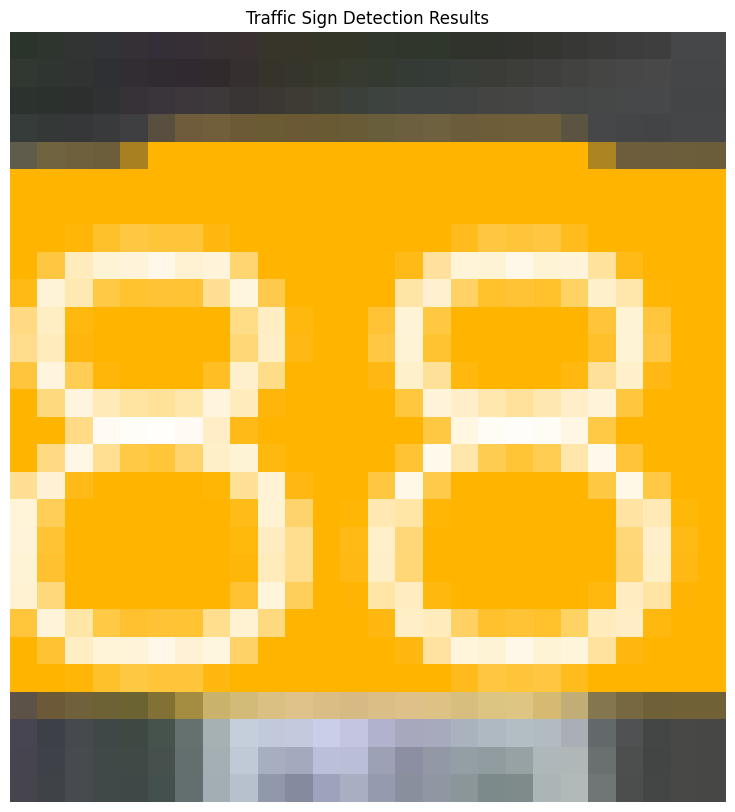

Output saved in: /content/runs/detect/test/00010_00064_00003.jpg


In [ ]:
import random
import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# Mount Google Drive
drive.mount('/content/drive')

# Load the trained model
model_path = '/content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection/traffic_sign_detection.pt'
model = YOLO(model_path)

# Verify that data.yaml and model exist
if not os.path.exists('/content/GTSRB_YOLO/data.yaml'):
    raise FileNotFoundError("data.yaml not found in /content/GTSRB_YOLO. Please ensure the dataset is loaded.")
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model {model_path} not found. Please check the path.")

# Select a random validation image for testing
val_images = glob.glob('/content/GTSRB_YOLO/images/val/*.jpg')
if not val_images:
    raise FileNotFoundError("No validation images found in /content/GTSRB_YOLO/images/val/")
test_image = random.choice(val_images)

# Run inference
results = model.predict(source=test_image, conf=0.5)

# Print detected objects
print(f"Tested on image: {test_image}")
print("Detected objects:")
for result in results:
    for box in result.boxes:
        class_id = int(box.cls)
        class_name = model.names[class_id]
        confidence = box.conf.item()
        print(f"Class: {class_name}, Confidence: {confidence:.2f}")

# Display the image with bounding boxes
output_img = results[0].plot()  # Draw bounding boxes and labels
plt.figure(figsize=(10, 10))
plt.imshow(output_img)
plt.axis('off')  # Hide axes
plt.title('Traffic Sign Detection Results')
plt.show()

# Save the output image
output_dir = '/content/runs/detect/test'
os.makedirs(output_dir, exist_ok=True)
output_filename = os.path.join(output_dir, os.path.basename(test_image))
results[0].save(filename=output_filename)
print(f"Output saved in: {output_filename}")

In [ ]:
# Install required libraries
!pip install ultralytics gradio

# Import libraries
from ultralytics import YOLO
from google.colab import drive
import gradio as gr
from PIL import Image

# Mount Google Drive
drive.mount('/content/drive')

# Copy the trained model to Colab
!cp /content/drive/MyDrive/YOLO_Checkpoints/traffic_sign_detection/traffic_sign_detection.pt /content/traffic_sign_detection.pt

# Load the trained model
model = YOLO('/content/traffic_sign_detection.pt')

# Define the prediction function
def predict(image):
    results = model.predict(image, conf=0.5)
    output_img = results[0].plot()  # Draw bounding boxes and labels
    return Image.fromarray(output_img)

# Create Gradio interface
iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Upload an Image"),
    outputs=gr.Image(type="pil", label="Detected Traffic Signs"),
    title="Traffic Sign Detection",
    description="Upload an image to detect traffic signs using YOLOv8."
)

# Launch the interface
iface.launch(share=True)  # Use share=True for a public URL (temporary in Colab free tier)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6416225d67204f8420.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
